                             row_time           msec   data
0       2024/12/30 05:57:54.751371214     580.738112  203.0
1       2024/12/30 05:57:54.752758728     582.125626  203.0
2       2024/12/30 05:57:54.754492054     583.858952  203.0
3       2024/12/30 05:57:54.756243024     585.609922  202.0
4       2024/12/30 05:57:54.757994543     587.361441  203.0
...                               ...            ...    ...
568373  2024/12/30 06:13:53.328699280  959158.066178  202.0
568374  2024/12/30 06:13:53.330484359  959159.851257  203.0
568375  2024/12/30 06:13:53.331995372  959161.362270  203.0
568376  2024/12/30 06:13:53.333915000  959163.281898  203.0
568377  2024/12/30 06:13:53.335561266  959164.928164  202.0

[568378 rows x 3 columns]
                            row_time           msec  header_stamp_secs  \
0      2024/12/30 05:57:54.170633102       0.000000               1928   
1      2024/12/30 05:57:54.542856676     372.223574               1928   
2      2024/12/30 05:57:54.6714

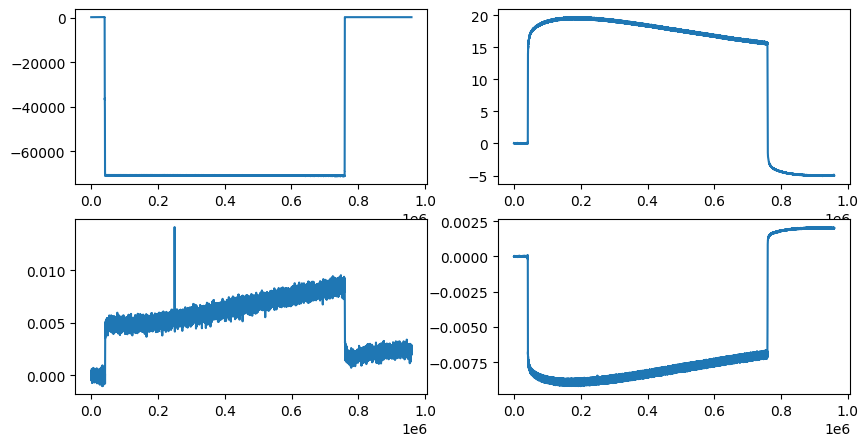

In [3]:
# import rclpy
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_new-pad_kyuchaku/sg_exp_new-pad_kyuchaku.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()


    


        

In [ ]:
import numpy as np

path = "./bag/sg_exp_fe_3/sg_exp_fe_3_0.db3"
bag_converter.connectDB(path)
res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
res3 = bag_converter.getTopicDataWithPandas("/sg/fe")




19104.665286
157755.564676


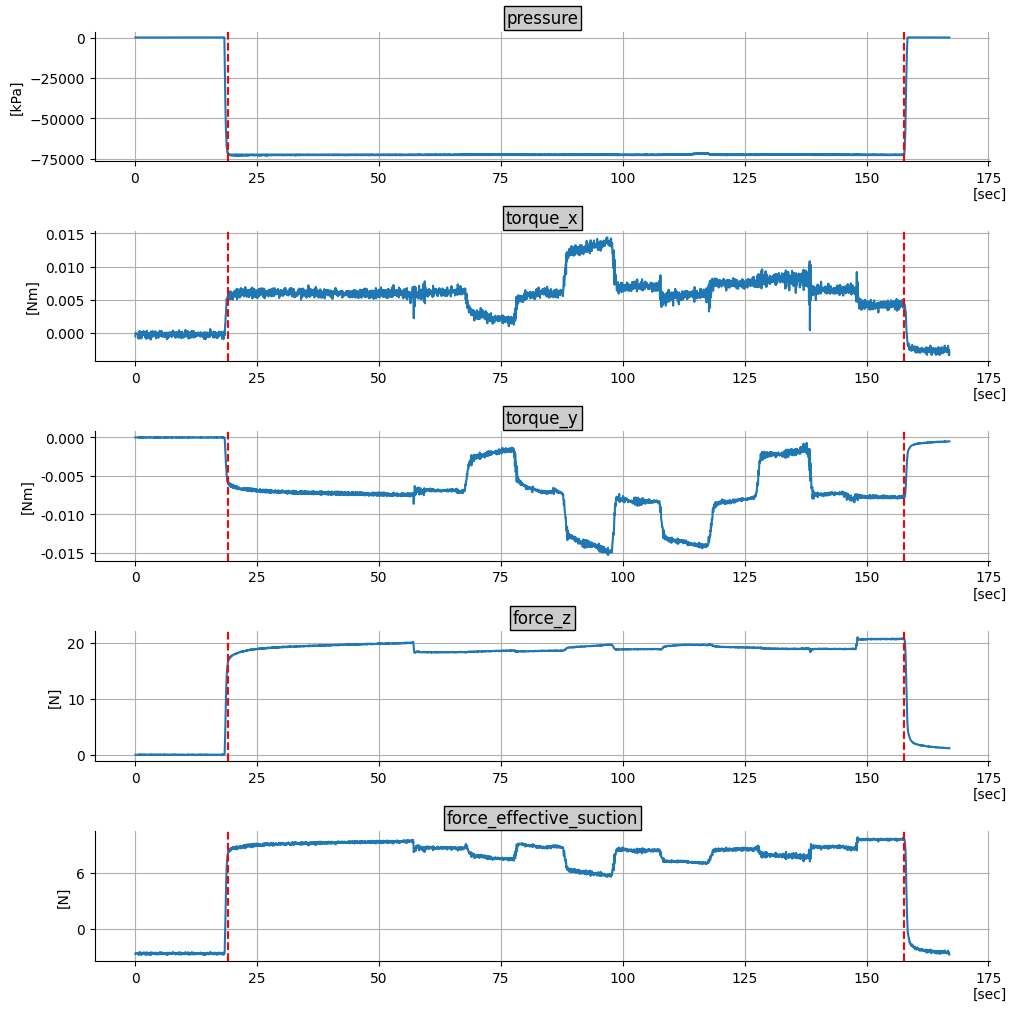

In [289]:
import matplotlib.ticker as ticker

def custom_plot(ax,x_label,y_label,title,msec_threshold_front,msec_threshold_back):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, 
                 bbox={'facecolor':'0.8', 'pad':2})
    ax.xaxis.set_label_coords(1.0, -0.2)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x/1000)))
    ax.grid(True)
    ax.axvline(x=msec_threshold_front, color='r', linestyle='--')
    ax.axvline(x=msec_threshold_back, color='r', linestyle='--')
    # ax.yaxis.set_label_coords(-0.05, 0.9)


msec_threshold_front = res1.loc[res1.index[(res1['data'] < res1['data'].min() + 1000 )& (res1['data'] > res1['data'].min())][0], "msec"]
print(msec_threshold_front)
msec_threshold_back = res1.loc[res1.index[(res1['data'] < res1['data'].min() + 1000 )& (res1['data'] > res1['data'].min())][-1], "msec"]
print(msec_threshold_back)

wrench_torque_x_front = res2.loc[(res2['msec'] - msec_threshold_front).abs().idxmin(), "wrench_torque_x"]
wrench_torque_x_back = res2.loc[(res2['msec'] - msec_threshold_back).abs().idxmin(), "wrench_torque_x"]
wrench_torque_y_front = res2.loc[(res2['msec'] - msec_threshold_front).abs().idxmin(), "wrench_torque_y"]
wrench_torque_y_back = res2.loc[(res2['msec'] - msec_threshold_back).abs().idxmin(), "wrench_torque_y"]

Mr = np.sqrt((res2['wrench_torque_x']-wrench_torque_x_front)**2 + (res2['wrench_torque_y']-wrench_torque_y_front)**2)
r = 0.0015
fr1 = 0.5*(res2['wrench_force_z']+Mr/r)
fr2 = 0.5*(res2['wrench_force_z']-Mr/r)
fe = np.minimum(fr1, fr2)  # 要素ごとの比較

fig ,axs= plt.subplots(nrows=5,figsize=(10, 10),layout='constrained')
axs[0].plot(res1['msec'], res1['data'])
custom_plot(axs[0],'[sec]','[kPa]','pressure',msec_threshold_front,msec_threshold_back)
axs[1].plot(res2['msec'], res2['wrench_torque_x'])
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.3f}'.format(x)))
custom_plot(axs[1],'[sec]','[Nm]','torque_x',msec_threshold_front,msec_threshold_back)
axs[2].plot(res2['msec'], res2['wrench_torque_y'])
axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.3f}'.format(x)))
custom_plot(axs[2],'[sec]','[Nm]','torque_y',msec_threshold_front,msec_threshold_back)
axs[3].plot(res2['msec'], res2['wrench_force_z'])
custom_plot(axs[3],'[sec]','[N]','force_z',msec_threshold_front,msec_threshold_back)
axs[4].plot(res2['msec'], fe)
custom_plot(axs[4],'[sec]','[N]','force_effective_suction', msec_threshold_front, msec_threshold_back)
axs[4].set_yticks(np.arange(0, fe.max(), 6))

plt.show()

                           row_time           msec  header_stamp_secs  \
0      2025/01/16 08:07:59.75911822       0.000000               2481   
1     2025/01/16 08:07:59.127494185      51.582363               2481   
2     2025/01/16 08:07:59.685633202     609.721380               2482   
3     2025/01/16 08:07:59.733462122     657.550300               2482   
4     2025/01/16 08:07:59.780909784     704.997962               2482   
...                             ...            ...                ...   
3321  2025/01/16 08:10:45.845522218  166769.610396               2648   
3322  2025/01/16 08:10:45.894132578  166818.220756               2648   
3323  2025/01/16 08:10:45.943594849  166867.683027               2648   
3324  2025/01/16 08:10:45.993229248  166917.317426               2648   
3325   2025/01/16 08:10:46.55432186  166979.520364               2648   

      header_stamp_nsecs header_frame_id  wrench_force_x  wrench_force_y  \
0              908000000             map       

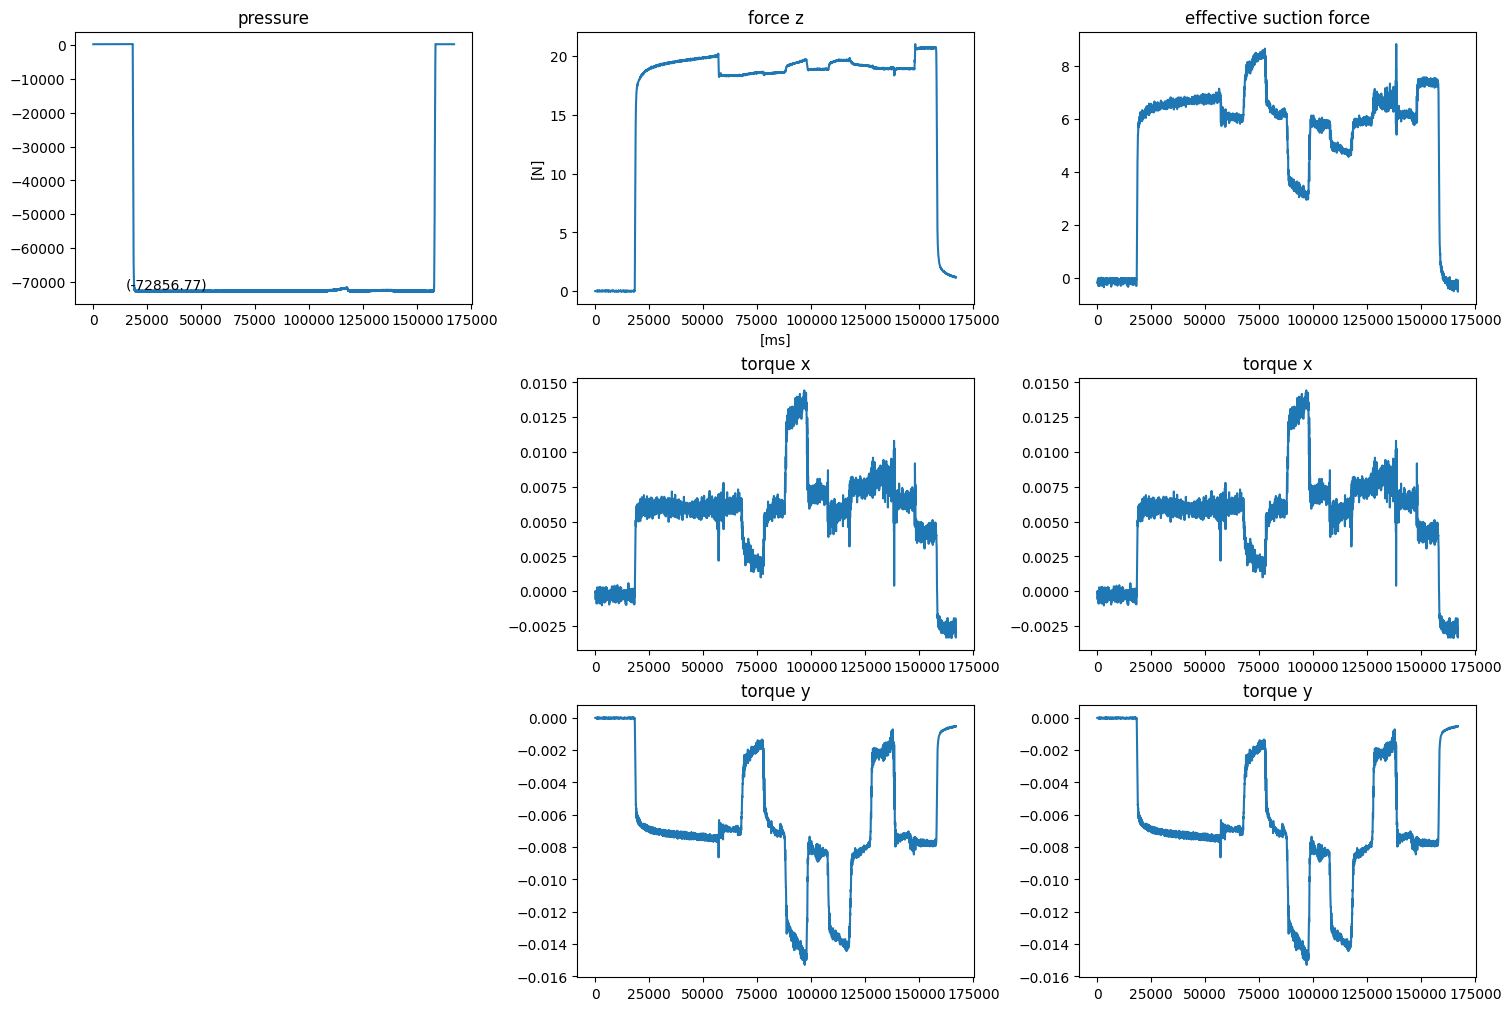

In [ ]:
fig ,axs= plt.subplots(nrows=4,figsize=(15, 10),layout='constrained')
axs[0].plot(res1['msec'], res1['data'])


fig = plt.figure(figsize=(15, 10),layout='constrained')
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 5)
ax4 = fig.add_subplot(3, 3, 8)
ax5 = fig.add_subplot(3, 3, 3)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 9)
ax1.plot(res1['msec'], res1['data'])
max_pressure = res1['data'].min()
ax1.text(15000,max_pressure, f"({max_pressure:.2f})", fontsize=10, ha='left', va='bottom')
ax1.set_title("pressure")

ax2.plot(res2['msec'], res2['wrench_force_z'])
ax2.set_title("force z")
ax2.set_xlabel("[ms]")
ax2.set_ylabel("[N]")
ax3.plot(res2['msec'], res2['wrench_torque_x'])
ax3.set_title("torque x")
ax4.plot(res2['msec'], res2['wrench_torque_y'])
ax4.set_title("torque y")
ax5.plot(res3['msec'], res3['data'])
ax5.set_title("effective suction force")
ax6.plot(res2['msec'], res2['wrench_torque_x'])
ax6.set_title("torque x")
ax7.plot(res2['msec'], res2['wrench_torque_y'])
ax7.set_title("torque y")
plt.show()

/tmp/ipykernel_10462/4290059981.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


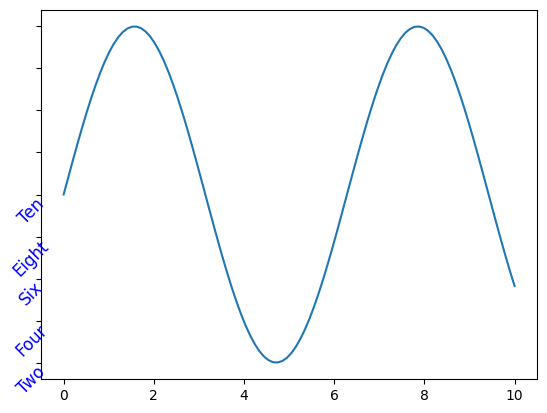

In [206]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y)

# 目盛り位置を設定
ax.set_xticks([0, 2, 4, 6, 8, 10])

# x軸ラベルを設定
ax.set_yticklabels(
    ['Zero', 'Two', 'Four', 'Six', 'Eight', 'Ten'],
    fontdict={'fontsize': 12, 'color': 'blue'},  # フォントサイズと色を指定
    rotation=45,  # 45度回転
    ha='center',  # 水平方向中央配置
    va='top',     # 垂直方向上配置
)

plt.show()

                             row_time           msec   data
0       2024/12/30 07:11:22.683962741       0.000000  203.0
1       2024/12/30 07:11:22.707331195      23.368454  203.0
2       2024/12/30 07:11:22.714082525      30.119784  203.0
3       2024/12/30 07:11:22.734039498      50.076757  203.0
4       2024/12/30 07:11:22.740528107      56.565366  203.0
...                               ...            ...    ...
115159   2024/12/30 07:14:37.80758224  194396.795483  203.0
115160   2024/12/30 07:14:37.82939507  194398.976766  203.0
115161   2024/12/30 07:14:37.83480009  194399.517268  203.0
115162   2024/12/30 07:14:37.85402063  194401.439322  203.0
115163   2024/12/30 07:14:37.86795172  194402.832431  203.0

[115164 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 07:11:23.107021620     423.058879               6337   
1     2024/12/30 07:11:23.154537440     470.574699               6337   
2     2024/12/30 07:11:23.20744759

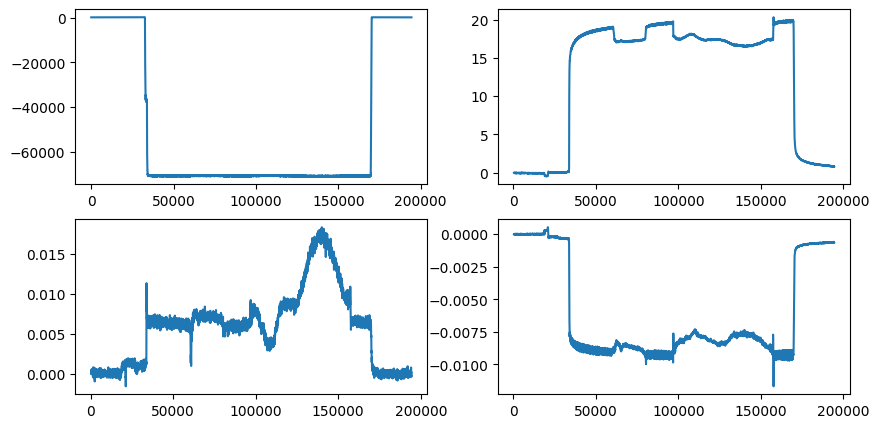

In [16]:
path = "./bag/sg_exp_new-pad_motiage_1/sg_exp_new-pad_motiage_1_0.db3"
bag_converter.connectDB(path)
res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
print(res1)
res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
print(res2)


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.plot(res1['msec'], res1['data'])
ax2.plot(res2['msec'], res2['wrench_force_z'])
ax3.plot(res2['msec'], res2['wrench_torque_x'])
ax4.plot(res2['msec'], res2['wrench_torque_y'])
plt.show()



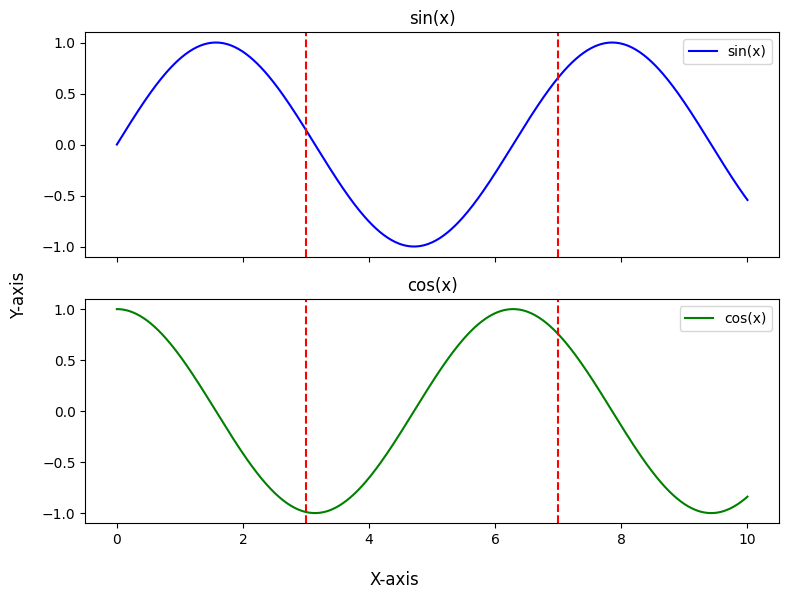

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# データを生成
x = np.linspace(0, 10, 500)
y1 = np.sin(x)
y2 = np.cos(x)

# 変化点のタイミング（例: x = 3 と x = 7）
change_points = [3, 7]

# 縦に並べたプロットを作成
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# プロット1: y1
axs[0].plot(x, y1, label="sin(x)", color="blue")
axs[0].set_title("sin(x)")
axs[0].legend()
axs[0].set_yticks()

# プロット2: y2
axs[1].plot(x, y2, label="cos(x)", color="green")
axs[1].set_title("cos(x)")
axs[1].legend()

# 変化点に垂直線を引く
for ax in axs:
    for cp in change_points:
        ax.axvline(x=cp, color="red", linestyle="--")

# 共有の x 軸ラベル
fig.supxlabel("X-axis")
fig.supylabel("Y-axis")

# ラベルの重複を防ぐ
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right", labels=["cos(x)"])  # 重複しないよう調整

plt.tight_layout()
plt.show()

                             row_time           msec   data
0       2024/12/30 07:18:27.446573463       0.000000  203.0
1       2024/12/30 07:18:27.465986587      19.413124  203.0
2       2024/12/30 07:18:27.469106933      22.533470  203.0
3       2024/12/30 07:18:27.472924561      26.351098  203.0
4       2024/12/30 07:18:27.476795161      30.221698  203.0
...                               ...            ...    ...
108608  2024/12/30 07:21:30.604597026  183158.023563  203.0
108609  2024/12/30 07:21:30.606431249  183159.857786  203.0
108610  2024/12/30 07:21:30.608272556  183161.699093  203.0
108611  2024/12/30 07:21:30.609814962  183163.241499  203.0
108612  2024/12/30 07:21:30.611263351  183164.689888  203.0

[108613 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 07:18:27.617764912     171.191449               6761   
1     2024/12/30 07:18:27.917636179     471.062716               6761   
2       2024/12/30 07:18:28.730153

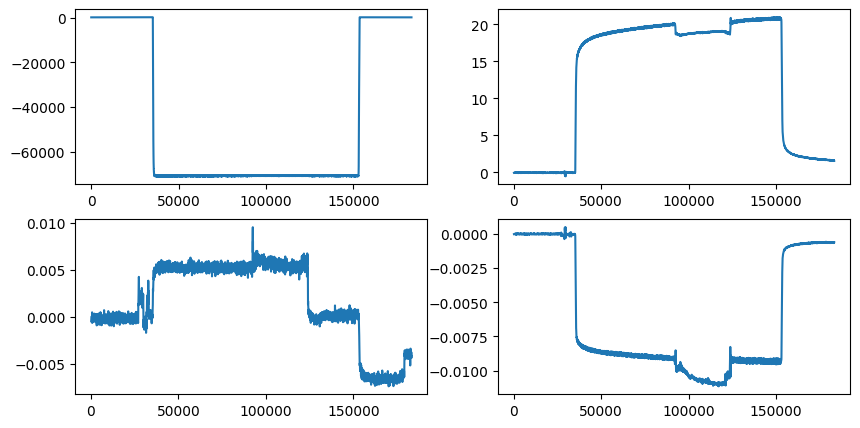

In [20]:
path = "./bag/sg_exp_new-pad_motiage_2/sg_exp_new-pad_motiage_2_0.db3"
bag_converter.connectDB(path)
res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
print(res1)
res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
print(res2)


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.plot(res1['msec'], res1['data'])
ax2.plot(res2['msec'], res2['wrench_force_z'])
ax3.plot(res2['msec'], res2['wrench_torque_x'])
ax4.plot(res2['msec'], res2['wrench_torque_y'])
plt.show()


                            row_time           msec   data
0      2024/12/30 07:25:14.159162617     382.381175  203.0
1      2024/12/30 07:25:14.159185604     382.404162  203.0
2      2024/12/30 07:25:14.159907822     383.126380  203.0
3      2024/12/30 07:25:14.161718125     384.936683  203.0
4      2024/12/30 07:25:14.163477614     386.696172  203.0
...                              ...            ...    ...
76149   2024/12/30 07:27:22.67826411  128291.044969  203.0
76150   2024/12/30 07:27:22.69419331  128292.637889  203.0
76151   2024/12/30 07:27:22.70938400  128294.156958  203.0
76152   2024/12/30 07:27:22.72639767  128295.858325  203.0
76153   2024/12/30 07:27:22.74497097  128297.715655  203.0

[76154 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 07:25:13.776781442       0.000000               7167   
1     2024/12/30 07:25:13.886413569     109.632127               7167   
2     2024/12/30 07:25:13.930947917     154.166

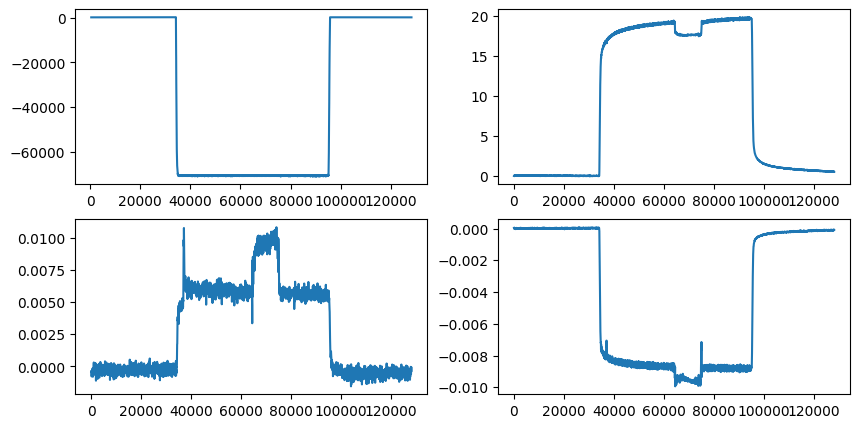

In [19]:
path = "./bag/sg_exp_new-pad_motiage_3/sg_exp_new-pad_motiage_3_0.db3"
bag_converter.connectDB(path)
res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
print(res1)
res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
print(res2)


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.plot(res1['msec'], res1['data'])
ax2.plot(res2['msec'], res2['wrench_force_z'])
ax3.plot(res2['msec'], res2['wrench_torque_x'])
ax4.plot(res2['msec'], res2['wrench_torque_y'])
plt.show()

                            row_time           msec   data
0      2024/12/30 07:37:05.911890304       0.000000  203.0
1      2024/12/30 07:37:05.911971211       0.080907  203.0
2      2024/12/30 07:37:05.914767251       2.876947  203.0
3      2024/12/30 07:37:05.917962697       6.072393  203.0
4      2024/12/30 07:37:05.921179105       9.288801  203.0
...                              ...            ...    ...
82536   2024/12/30 07:39:25.22909607  139111.019303  203.0
82537   2024/12/30 07:39:25.25287074  139113.396770  203.0
82538   2024/12/30 07:39:25.26907971  139115.017667  203.0
82539   2024/12/30 07:39:25.28599095  139116.708791  203.0
82540   2024/12/30 07:39:25.38065687  139126.175383  203.0

[82541 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 07:37:06.290552952     378.662648               7880   
1     2024/12/30 07:37:06.417111066     505.220762               7880   
2     2024/12/30 07:37:06.466740212     554.849

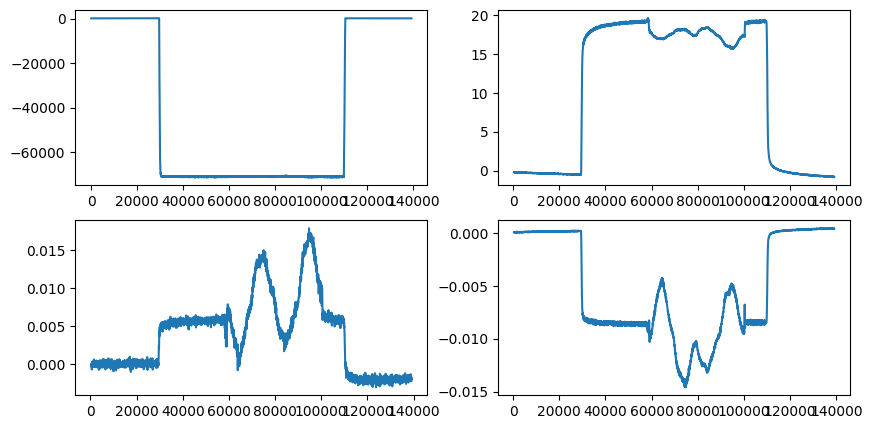

In [23]:
# import rclpy
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_new-pad_moment_1/sg_exp_new-pad_moment_1_0.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()


                            row_time           msec   data
0      2024/12/30 07:49:24.569772970       0.000000  203.0
1      2024/12/30 07:49:24.576810536       7.037566  203.0
2      2024/12/30 07:49:24.583621702      13.848732  203.0
3      2024/12/30 07:49:24.594666195      24.893225  203.0
4      2024/12/30 07:49:24.609737380      39.964410  203.0
...                              ...            ...    ...
83294  2024/12/30 07:51:45.426375820  140856.602850  203.0
83295  2024/12/30 07:51:45.428150945  140858.377975  203.0
83296  2024/12/30 07:51:45.429721971  140859.949001  203.0
83297  2024/12/30 07:51:45.431370585  140861.597615  203.0
83298  2024/12/30 07:51:45.432996637  140863.223667  203.0

[83299 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 07:49:24.887697742     317.924772               8618   
1     2024/12/30 07:49:24.992603924     422.830954               8619   
2      2024/12/30 07:49:25.42274264     472.501

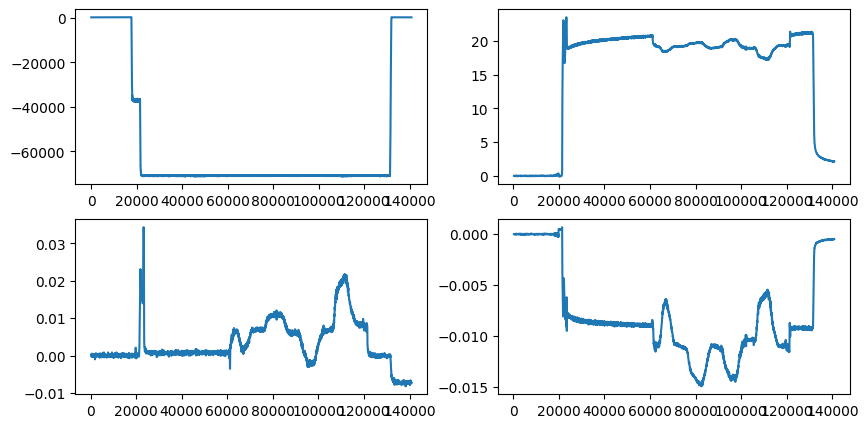

In [28]:
# import rclpy
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_new-pad_moment_2/sg_exp_new-pad_moment_2_0.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()

                            row_time           msec   data
0      2024/12/30 07:54:19.888430169       0.000000  203.0
1      2024/12/30 07:54:19.888448301       0.018132  203.0
2      2024/12/30 07:54:19.888521296       0.091127  203.0
3      2024/12/30 07:54:19.888537311       0.107142  203.0
4      2024/12/30 07:54:19.888542998       0.112829  203.0
...                              ...            ...    ...
90161  2024/12/30 07:56:52.480149758  152591.719589  203.0
90162  2024/12/30 07:56:52.481772446  152593.342277  203.0
90163  2024/12/30 07:56:52.483710520  152595.280351  203.0
90164  2024/12/30 07:56:52.485212181  152596.782012  203.0
90165  2024/12/30 07:56:52.486724148  152598.293979  203.0

[90166 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 07:54:20.416110251     527.680082               8914   
1     2024/12/30 07:54:20.464242611     575.812442               8914   
2     2024/12/30 07:54:20.514235930     625.805

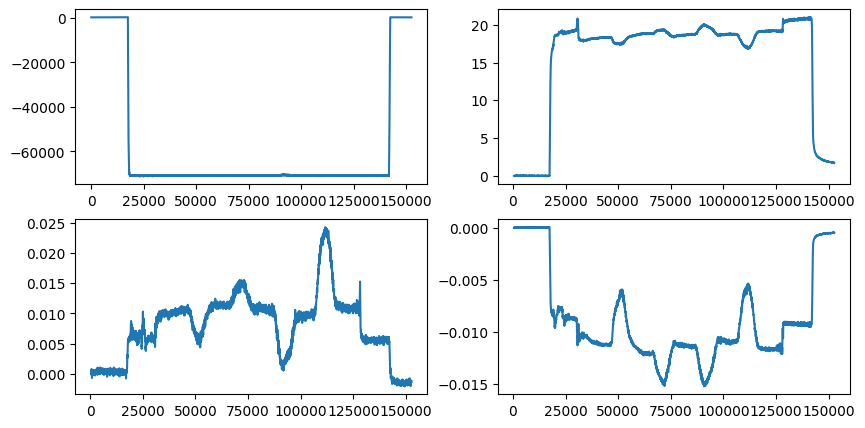

In [27]:
# import rclpy
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_new-pad_moment_3/sg_exp_new-pad_moment_3_0.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()

                             row_time           msec   data
0       2024/12/30 08:24:52.580343840       0.000000  203.0
1       2024/12/30 08:24:52.583826121       3.482281  203.0
2       2024/12/30 08:24:52.591921637      11.577797  203.0
3       2024/12/30 08:24:52.598598623      18.254783  203.0
4       2024/12/30 08:24:52.627603436      47.259596  203.0
...                               ...            ...    ...
469991  2024/12/30 08:38:22.574977935  809994.634095  203.0
469992  2024/12/30 08:38:22.574995446  809994.651606  203.0
469993  2024/12/30 08:38:22.575881907  809995.538067  203.0
469994  2024/12/30 08:38:22.577613733  809997.269893  203.0
469995  2024/12/30 08:38:22.579118450  809998.774610  203.0

[469996 rows x 3 columns]
                            row_time           msec  header_stamp_secs  \
0      2024/12/30 08:24:52.881638306     301.294466                391   
1      2024/12/30 08:24:52.991830279     411.486439                391   
2       2024/12/30 08:24:53.318

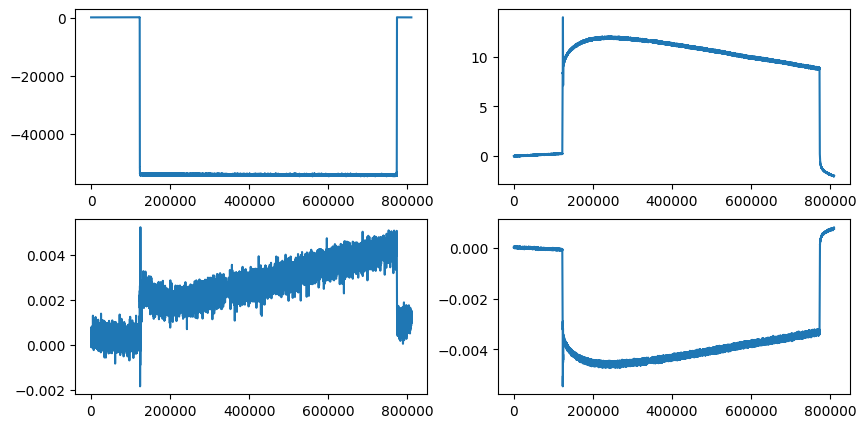

In [31]:
# import rclpy
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_old-pad_kyuchaku/sg_exp_old-pad_kyuchaku_0.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()


                            row_time           msec   data
0      2024/12/30 08:43:41.778127042       0.000000  203.0
1      2024/12/30 08:43:41.791103654      12.976612  203.0
2      2024/12/30 08:43:41.804934330      26.807288  203.0
3      2024/12/30 08:43:41.811176393      33.049351  203.0
4      2024/12/30 08:43:41.818145788      40.018746  203.0
...                              ...            ...    ...
62694  2024/12/30 08:45:27.717535334  105939.408292  203.0
62695  2024/12/30 08:45:27.719166723  105941.039681  203.0
62696  2024/12/30 08:45:27.720851120  105942.724078  203.0
62697  2024/12/30 08:45:27.722641617  105944.514575  203.0
62698  2024/12/30 08:45:27.724394994  105946.267952  203.0

[62699 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 08:43:41.787752341       9.625299               1519   
1     2024/12/30 08:43:42.283727092     505.600050               1520   
2     2024/12/30 08:43:42.351371526     573.244

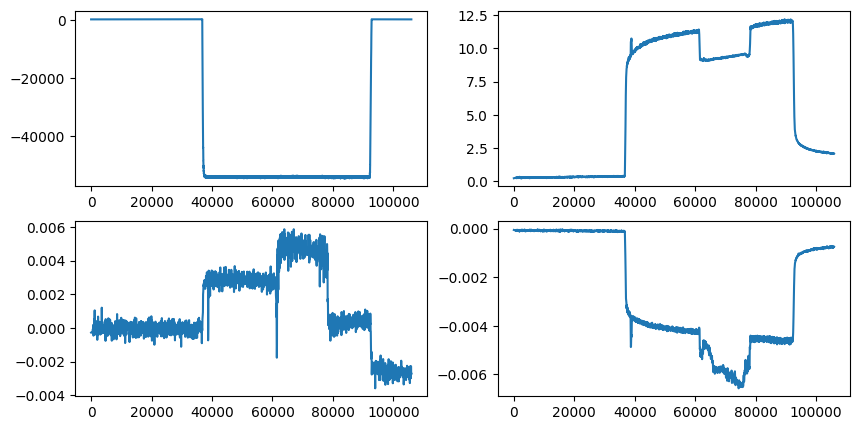

In [32]:
# import rclpy
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_old-pad_motiage_1/sg_exp_old-pad_motiage_1_0.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()

                            row_time           msec   data
0      2024/12/30 08:49:26.306283977       0.000000  203.0
1      2024/12/30 08:49:26.308221525       1.937548  203.0
2      2024/12/30 08:49:26.314578138       8.294161  203.0
3      2024/12/30 08:49:26.314612432       8.328455  203.0
4      2024/12/30 08:49:26.314617692       8.333715  203.0
...                              ...            ...    ...
84719  2024/12/30 08:51:50.294455299  143988.171322  203.0
84720  2024/12/30 08:51:50.296018990  143989.735013  203.0
84721  2024/12/30 08:51:50.297790116  143991.506139  203.0
84722  2024/12/30 08:51:50.299298678  143993.014701  203.0
84723  2024/12/30 08:51:50.301005007  143994.721030  203.0

[84724 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 08:49:26.775873617     469.589640               1864   
1     2024/12/30 08:49:26.892998354     586.714377               1865   
2     2024/12/30 08:49:26.943571161     637.287

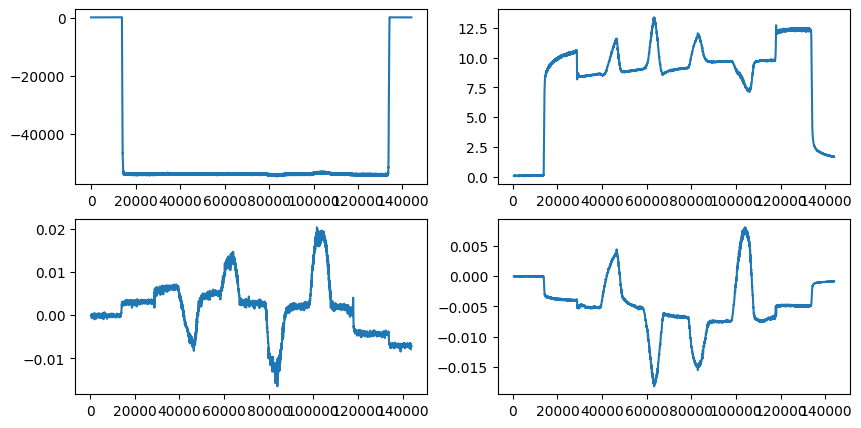

In [33]:
# import rclpy
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_old-pad_moment_1/sg_exp_old-pad_moment_1_0.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()

                             row_time           msec   data
0        2024/12/30 08:54:40.38954231       0.000000  203.0
1        2024/12/30 08:54:40.45321155       6.366924  203.0
2        2024/12/30 08:54:40.58209833      19.255602  203.0
3        2024/12/30 08:54:40.70978547      32.024316  203.0
4        2024/12/30 08:54:40.74204203      35.249972  203.0
...                               ...            ...    ...
125873  2024/12/30 08:58:13.490903915  213451.949684  202.0
125874  2024/12/30 08:58:13.490913559  213451.959328  203.0
125875  2024/12/30 08:58:13.490918881  213451.964650  203.0
125876  2024/12/30 08:58:13.493139861  213454.185630  203.0
125877  2024/12/30 08:58:13.494124208  213455.169977  203.0

[125878 rows x 3 columns]
                           row_time           msec  header_stamp_secs  \
0     2024/12/30 08:54:40.328516020     289.561789               2178   
1     2024/12/30 08:54:40.376855323     337.901092               2178   
2     2024/12/30 08:54:40.42582124

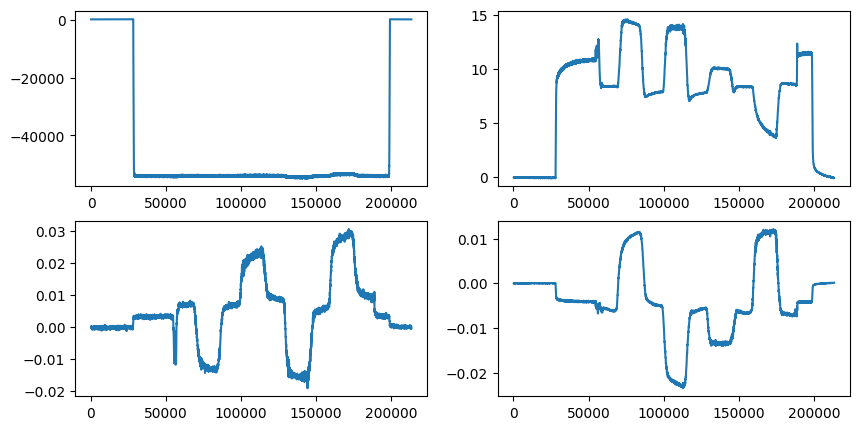

In [34]:
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
import sys
import pandas as pd
import bag_converter
import matplotlib.pyplot as plt

if __name__ == "__main__":
    bag_converter = bag_converter.BagConverter()
    args = sys.argv
    if len(args) < 2:
        print("Usage: python3 bag_converter.py <bag_file>")
        exit(1)
    else:
        bag_file = args[1]

    path = "./bag/sg_exp_old-pad_moment_2/sg_exp_old-pad_moment_2_0.db3"
    bag_converter.connectDB(path)
    res1 = bag_converter.getTopicDataWithPandas("/sg/pressure")
    print(res1)
    res2 = bag_converter.getTopicDataWithPandas("/sg/wrench")
    print(res2)


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.plot(res1['msec'], res1['data'])
    ax2.plot(res2['msec'], res2['wrench_force_z'])
    ax3.plot(res2['msec'], res2['wrench_torque_x'])
    ax4.plot(res2['msec'], res2['wrench_torque_y'])
    plt.show()